# 1. Method 1

1. Create bootstrap candidate/noncandidate sample from candidate/noncandidate pool of dfe_alpha output values.
>`bs(cand)`, `bs(noncand)`
2. Create `null population` by joining bootstrap candidate and noncandidate samples
>`null_pop = bs(cand) + bs(noncand)`
3. Bootstrap sample two samples from null population, and assign as `candidate` and `noncandidate`. Repeat 1000 times. 
>`mock_candidate = bs(null_pop)`
>`mock_noncandidate = bs(null_population)`
4. Calculate null population mean and standard deviation of `mock_candidate - mock_candidate`
5. Calculate sample mean from the original candidate/noncandidate pool of dfe_alpha output values.
6. Calculate p-value using z-scores. 
>`z = (sample_mean - population_mean)/(population_std/sqrt(sample_n))`


In [190]:
import pandas as pd
from sklearn.utils import resample
import random
import matplotlib.pyplot as plt
from scipy import stats
import math
import scipy

In [191]:
df = pd.read_csv("../../data/dfe_alpha_analysis/20210204_composite_genome/bootstrap_values.txt", sep='\t')
df.columns = ["group","alpha", "omega","pFDM", "NeS_0_1", "NeS_1_10", "NeS_10_100", "NeS_100_99"]
df = df.drop(columns=["pFDM"])

In [192]:
df.head()

,group,alpha,omega,NeS_0_1,NeS_1_10,NeS_10_100,NeS_100_99
0,noncandidate,0.264506,0.085500,0.252094,0.061857,0.077035,0.609015
1,candidate,0.486018,0.145958,0.166344,0.055530,0.074067,0.704058
2,noncandidate,0.203251,0.064773,0.266185,0.050104,0.059535,0.624176
3,candidate,0.438839,0.130599,0.177601,0.046088,0.058048,0.718262
4,noncandidate,0.354435,0.116164,0.226874,0.070282,0.092047,0.610797


In [193]:
# construct the simulated null population distribution
population= pd.DataFrame(columns = ["alpha", "omega", "NeS_0_1", "NeS_1_10", "NeS_10_100", "NeS_100_99"])

for i in range(1000):
    random.seed(i)
    
    #Resample candidates and noncandidates
    candidate_bs = resample(df[df.group == 'candidate'], replace=True, n_samples=100, random_state=1)
    noncandidate_bs = resample(df[df.group == 'noncandidate'], replace=True, n_samples=100, random_state=1)
    
    #join to create null population pool
    joint_bs = candidate_bs.append(noncandidate_bs)
    
    #Resample to create mock candidate and noncandidates form null population
    mock_candidate = resample(joint_bs, replace=True, n_samples=100, random_state=random.randint(0,10000))
    mock_noncandidate = resample(joint_bs, replace=True, n_samples=100, random_state=random.randint(0,10000))
    
    #Calculate mean and standard deviation of candidate-noncandidate
    mean_c = mock_candidate.agg(['mean'])
    mean_nc = mock_noncandidate.agg(['mean'])
    var_c = mock_candidate.agg(['std']).apply(lambda x: x**2)
    var_nc = mock_noncandidate.agg(['std']).apply(lambda x: x**2)
    output_std = pd.Series((var_c+var_nc).apply(lambda x: math.sqrt(x)), name = 'std')
    output = mean_c-mean_nc
    
    #Add mean and std to a running dataframe 
    population = population.append(output.append(output_std))

In [194]:
# the simulated mean and standard deviation of the null population distribution (estimated with bootstrapping)
population_summary = population[population.index == 'mean'].agg(['mean'])
population_summary = population_summary.append(sample[population.index == 'std'].agg(['mean']))
population_summary = population_summary.reset_index()
population_summary.index = ['mean', 'std']

In [195]:
population_summary

,index,alpha,omega,NeS_0_1,NeS_1_10,NeS_10_100,NeS_100_99
mean,mean,0.000913,0.000202,-0.000413,0.000101,0.000185,0.000126
std,mean,0.096278,0.025859,0.039398,0.017619,0.028611,0.053488


In [196]:
# the mean and standard deviation of the sample distribution
c_summary = df[df.group == 'candidate'].agg(['mean','std', 'median'])
nc_summary = df[df.group == 'noncandidate'].agg(['mean','std', 'median'])
df_summary = c_summary - nc_summary
std_tmp = c_summary[c_summary.index == 'std'].apply(lambda x: x**2) + nc_summary[nc_summary.index == 'std'].apply(lambda x: x**2)
std_tmp = pd.Series(std_tmp.apply(lambda x: math.sqrt(x)), name = 'std')
df_summary = df_summary.drop(index = 'std').append(std_tmp)

In [197]:
df_summary

,alpha,omega,NeS_0_1,NeS_1_10,NeS_10_100,NeS_100_99
mean,0.101022,0.021351,-0.050461,0.002053,0.007490,0.040918
median,0.099108,0.021184,-0.049534,0.000850,0.003727,0.050882
std,0.065176,0.021203,0.016843,0.017703,0.028365,0.045219


#### Calculate p-value
z = (mean of sample - mean of population)/(population std/sqrt(sample_n))

In [198]:
sample_mean = df_summary.loc['mean',]
population_mean = population_summary.loc['mean',]
population_std = population_summary.loc['std',]
sample_n = 100
z = (sample_mean - population_mean)/(population_std)*math.sqrt(sample_n)
p_value = z.apply(lambda x: scipy.stats.norm.sf(abs(x))*2).drop(['index'])#twosided

In [200]:
#how often is bs_diff greater than candidate(value)-noncandidate(value)?
sample_stats = pd.DataFrame(columns = ["alpha", "omega", "NeS_0_1", "NeS_1_10", "NeS_10_100", "NeS_100_99"], 
                            index = ['pop>sample', 'pop<sample','p_value'])
for col in sample_stats.columns:
    greater = sum([1 for i in population.loc['mean',col] if i > df_summary.loc['mean',col]])
    sample_stats.loc['pop>sample',col] = greater
    less = sum([1 for i in population.loc['mean',col] if i < df_summary.loc['mean',col]])
    sample_stats.loc['pop<sample',col] = less
    sample_stats.loc['p_value',col]= greater/sum([greater, less])

In [201]:
sample_stats

,alpha,omega,NeS_0_1,NeS_1_10,NeS_10_100,NeS_100_99
pop>sample,0,0,1000,135,2,0
pop<sample,1000,1000,0,865,998,1000
p_value,0,0,1,0.135,0.002,0


population mean = 0.00091
population sd = 0.09628
sample mean = 0.10102
z-score p-value = 0.0
boostrap p-value = 0.0



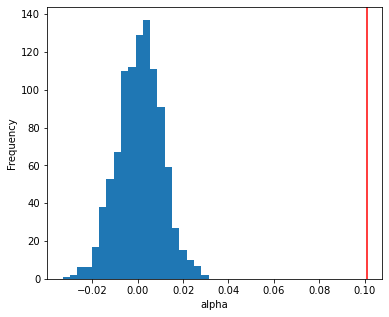

population mean = 0.0002
population sd = 0.02586
sample mean = 0.02135
z-score p-value = 0.0
boostrap p-value = 0.0



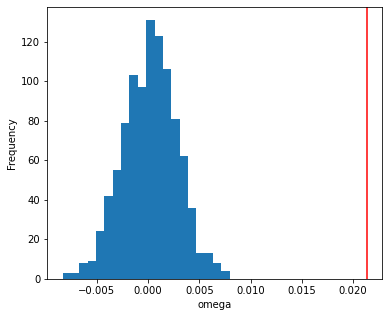

population mean = -0.00041
population sd = 0.0394
sample mean = -0.05046
z-score p-value = 0.0
boostrap p-value = 1.0



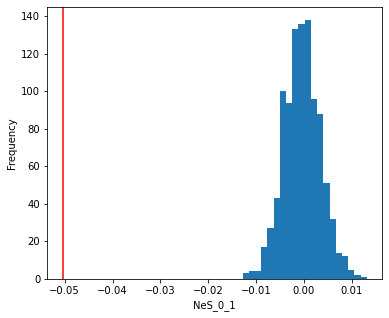

population mean = 0.0001
population sd = 0.01762
sample mean = 0.00205
z-score p-value = 0.26785
boostrap p-value = 0.135



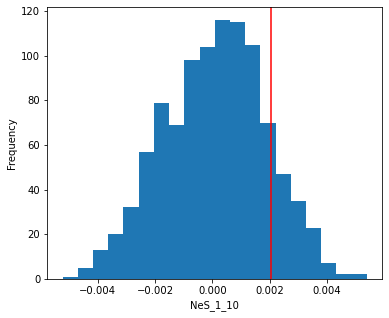

population mean = 0.00019
population sd = 0.02861
sample mean = 0.00749
z-score p-value = 0.01067
boostrap p-value = 0.002



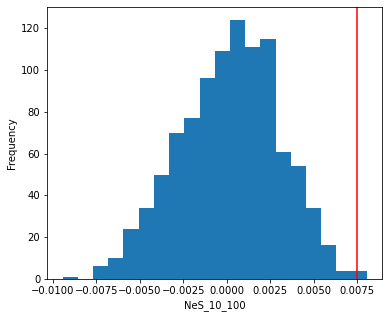

population mean = 0.00013
population sd = 0.05349
sample mean = 0.04092
z-score p-value = 0.0
boostrap p-value = 0.0



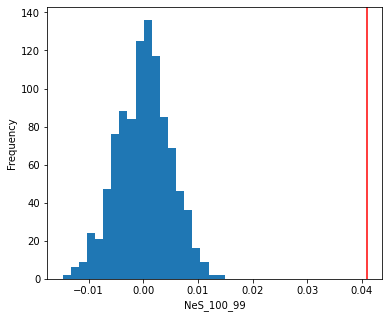

In [202]:

for col in sample.columns:
    
    #annotation
    text_string = "population mean = {}\n".format(round(population_summary.loc['mean',col], 5))+ \
                    "population sd = {}\n".format(round(population_summary.loc['std',col], 5))+ \
                    "sample mean = {}\n".format(round(df_summary.loc['mean',col],5)) + \
                    'z-score p-value = {}\n'.format(round(p_value[col],5)) + \
                    'boostrap p-value = {}\n'.format(round(sample_stats.loc['p_value',col],5))
    #confidence_int = "95% confidence interval: (" + str(round(sample_summary.loc['mean',col] - 2*sample_summary.loc['std',col], 5)) + ", " + \
    #                str(round(sample_summary.loc['mean',col] + 2*sample_summary.loc['std',col], 5)) +")"
    print(text_string)
    
    plt.figure(figsize=(6, 5))
    population[population.index == 'mean'][col].plot(kind = "hist", density = False, bins = 20)
    #sample_diff[col].plot(kind = "kde")
    #plt.ylabel('Counts')
    plt.xlabel(col)
    
    #ax.set_ylim(0, 1)

    plt.axvline(x = df_summary.loc['mean',col], color = 'red', label='sample mean\nx = {}'.format(df_summary.loc['mean',col]))
    plt.show()
    #plt.grid(None) 

# Method 2
1. Create bootstrap candidate/noncandidate sample from candidate/noncandidate pool of dfe_alpha output values. Reppeat 10000 times.
>`bs(cand)`, `bs(noncand)`
2. Calculate `bs(cand)-bs(noncand)` for each boostrap run.
3. Count how often is `bs(cand)-bs(noncand)` greater than `cand-noncand`
4. Use binomial test to calculate `p_value`

In [181]:
df = pd.read_csv("../../data/dfe_alpha_analysis/20210204_composite_genome/bootstrap_values.txt", sep='\t')
df.columns = ["group","alpha", "omega","pFDM", "NeS_0_1", "NeS_1_10", "NeS_10_100", "NeS_100_99"]
df = df.drop(columns=["pFDM"])

In [182]:
# construct the simulated null population distribution
population= pd.DataFrame(columns = ["alpha", "omega", "NeS_0_1", "NeS_1_10", "NeS_10_100", "NeS_100_99"])

for i in range(1000):
    random.seed(i)
    
    #Resample candidates and noncandidates
    candidate_bs = resample(df, replace=True, n_samples=100, random_state=random.randint(0,10000)).drop(columns = 'group')
    noncandidate_bs = resample(df, replace=True, n_samples=100, random_state=random.randint(0,10000)).drop(columns = 'group')
    #calculate bs(cand) - bs(noncand)
    bs_diff = candidate_bs.agg(['mean'])-noncandidate_bs.agg(['mean'])
    
    population = population.append(bs_diff)

In [183]:
# the mean and standard deviation of the sample distribution
c_summary = df[df.group == 'candidate'].agg(['mean','std', 'median'])
nc_summary = df[df.group == 'noncandidate'].agg(['mean','std', 'median'])
df_summary = c_summary - nc_summary
std_tmp = c_summary[c_summary.index == 'std'].apply(lambda x: x**2) + nc_summary[nc_summary.index == 'std'].apply(lambda x: x**2)
std_tmp = pd.Series(std_tmp.apply(lambda x: math.sqrt(x)), name = 'std')
df_summary = df_summary.drop(index = 'std').append(std_tmp)

In [184]:
df_summary

,alpha,omega,NeS_0_1,NeS_1_10,NeS_10_100,NeS_100_99
mean,0.101022,0.021351,-0.050461,0.002053,0.007490,0.040918
median,0.099108,0.021184,-0.049534,0.000850,0.003727,0.050882
std,0.065176,0.021203,0.016843,0.017703,0.028365,0.045219


In [185]:
#how often is bs_diff greater than candidate(value)-noncandidate(value)?
sample_stats = pd.DataFrame(columns = ["alpha", "omega", "NeS_0_1", "NeS_1_10", "NeS_10_100", "NeS_100_99"], 
                            index = ['pop>sample', 'pop<sample', 'p_value'])
for col in sample_stats.columns:
    greater = sum([1 for i in population[col] if i > df_summary.loc['mean',col]])
    sample_stats.loc['pop>sample',col] = greater
    less = sum([1 for i in population[col] if i < df_summary.loc['mean',col]])
    sample_stats.loc['pop<sample',col] = less
    sample_stats.loc['p_value',col]= greater/sum([greater, less])

In [186]:
sample_stats

,alpha,omega,NeS_0_1,NeS_1_10,NeS_10_100,NeS_100_99
pop>sample,0,0,1000,127,2,0
pop<sample,1000,1000,0,873,998,1000
binomial_p_value,1,1,9.33264e-302,1,1,1
p_value,0,0,1,0.127,0.002,0
